### Repeated measures ANOVA with two within-subject factors

Based on [Breska & Deouell (2017)](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2001665)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.stats import f

# Set styles for plotting
sns.set_style('whitegrid')
sns.set_context('talk')

In [11]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of subjects and levels
n_subjects = 21
levels_target = ['Valid','Invalid']
n_targets = len(levels_target)
levels_temporal = ['Rhythmic','Random']
n_temporal = len(levels_temporal)

# Mean values and standard deviation for each level
means = np.array([[225, 295], [280, 300]]) # columns are Valid / Invalid, rows are Rhythmic / Random
std_dev_sbj = 115 # this is the st. dev. across participants
std_dev_wthn = 40 # this is the st. dev. within participants

# Simulate data ensuring values are between 0 and 100
data = []
for subject in range(0, n_subjects):
    sbj_avg = np.random.normal(0, std_dev_sbj)
    for ltmp in range(0, n_temporal):
        for ltrgt in range(0, n_targets):
            value = np.random.normal(means[ltmp,ltrgt], std_dev_wthn)
            value = value+sbj_avg  # Ensure value is between 0 and 100
            data.append([subject+1, levels_temporal[ltmp], levels_target[ltrgt], value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Subject', 'Temporal', 'Target', 'Response time'])

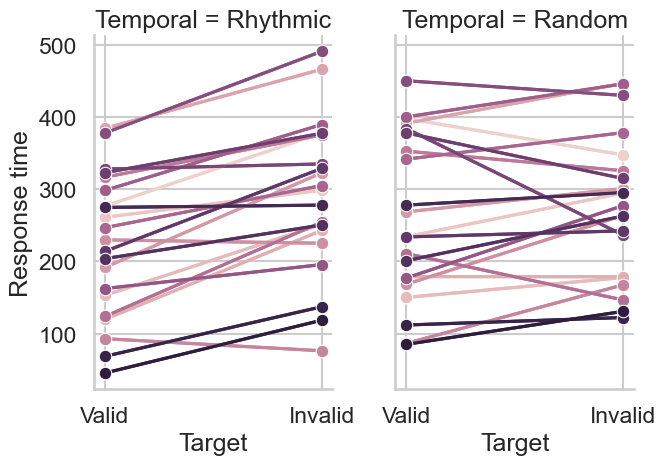

In [35]:
# Plot the data
g = sns.FacetGrid(data=df, col='Temporal', height=5, aspect=0.7)
g.map_dataframe(sns.lineplot, x='Target', y='Response time', hue='Subject', marker='o')
g.map_dataframe(sns.lineplot, x='Target', y='Response time', hue='Subject', marker='o')
plt.tight_layout()
plt.show()

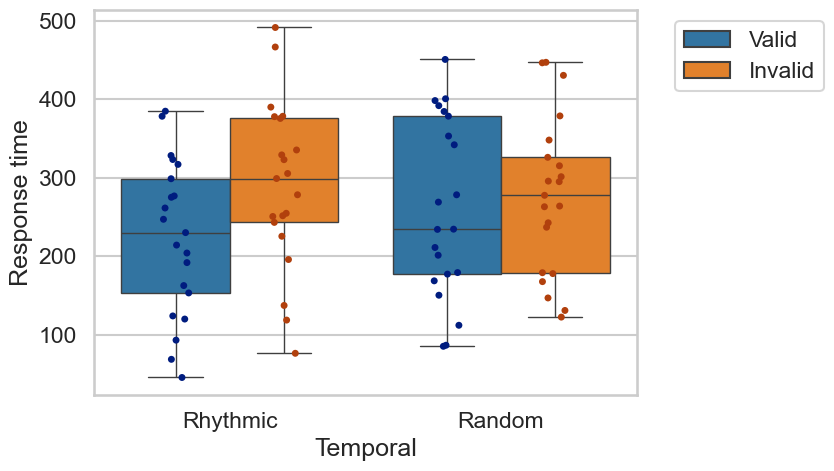

In [29]:
# Overlay both conditions, using a boxplot and strip plot
plt.figure(figsize=(7,5))
boxplot = sns.boxplot(data=df, x='Temporal', hue='Target', y='Response time')
handles, labels = boxplot.get_legend_handles_labels()
sns.stripplot(data=df, x='Temporal', hue='Target', y='Response time', dodge=True, palette='dark')
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [34]:
# Run the repeated-measures ANOVA
# df_long = pd.melt(df, id_vars=['Subject'], var_name='Condition', value_name='Response time')
# df_long[['Fact1','Fact2']] = df_long['Condition'].str.split('_', expand=True)
# df_long.describe()
aov = pg.rm_anova(dv='Response time', within=['Temporal','Target'], subject='Subject', data=df, detailed=True, effsize="ng2")
# Display the overall results
print(aov)

              Source            SS  ddof1  ddof2            MS          F  \
0           Temporal   2721.192287      1     20   2721.192287   2.450741   
1             Target  34820.117276      1     20  34820.117276  31.383747   
2  Temporal * Target  14377.334806      1     20  14377.334806   8.217296   

      p-unc  p-GG-corr       ng2  eps  
0  0.133155   0.133155  0.003073  1.0  
1  0.000018   0.000018  0.037951  1.0  
2  0.009539   0.009539  0.016027  1.0  


c:\Users\zsxbo\miniconda3\envs\stats\Lib\site-packages\pingouin\distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
c:\Users\zsxbo\miniconda3\envs\stats\Lib\site-packages\pingouin\distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


### Test for sphericity

In [30]:
# Display the result of Mauchly's test for sphericity
spher, W, chi2, dof, pval = pg.sphericity(data=df, dv='Response time', within=['Temporal', 'Target'], subject='Subject')
print(f'Sphericity: W = {W:.3f}, dof = {dof}, p = {pval:.3f}')

Sphericity: W = nan, dof = 1, p = 1.000


c:\Users\zsxbo\miniconda3\envs\stats\Lib\site-packages\pingouin\distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
c:\Users\zsxbo\miniconda3\envs\stats\Lib\site-packages\pingouin\distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


### Multiple comparisons

In [18]:
# Calculate expected marginal means
# Pairwise Comparisons
posthocs = pg.pairwise_tests(dv='Response time', within=['Temporal','Target'], subject='Subject', data=df, padjust='bonf')
print(posthocs)

            Contrast  Temporal        A         B Paired Parametric         T  \
0           Temporal         -   Random  Rhythmic   True       True  1.565484   
1             Target         -  Invalid     Valid   True       True  5.602120   
2  Temporal * Target    Random  Invalid     Valid   True       True  1.103232   
3  Temporal * Target  Rhythmic  Invalid     Valid   True       True  6.747495   

    dof alternative     p-unc    p-corr p-adjust       BF10    hedges  
0  20.0   two-sided  0.133155       NaN      NaN      0.651  0.109947  
1  20.0   two-sided  0.000018       NaN      NaN   1322.553  0.393298  
2  20.0   two-sided  0.283025  0.566050     bonf      0.389  0.133262  
3  20.0   two-sided  0.000001  0.000003     bonf  1.272e+04  0.637834  
